In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [92]:
from __future__ import division

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.sparse as sps
import scipy.linalg as sl


import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import utils
from enterprise.signals import gp_signals
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

def fpStat(psr, f0):
    """
    Computes the Fp-statistic as defined in Ellis, Siemens, Creighton (2012)
    :param psr: List of pulsar object instances
    :param f0: Gravitational wave frequency
    :return: Value of the Fp statistic evaluated at f0
    """

    fstat=0.
    npsr = len(psr)

    # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
    N = np.zeros(2)
    # define M matrix M_ij=(A_i|A_j)
    M = np.zeros((2, 2))
    for ii,p in enumerate(psr):

        # Define A vector
        A = np.zeros((2, len(p.toas)))
        A[0,:] = 1./f0**(1./3.) * np.sin(2*np.pi*f0*p.toas)
        A[1,:] = 1./f0**(1./3.) * np.cos(2*np.pi*f0*p.toas)

        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.array([np.dot(A[0,:], np.dot(p.invCov, p.residuals)), \
                      np.dot(A[1,:], np.dot(p.invCov, p.residuals))]) 
        
        # define M matrix M_ij=(A_i|A_j)
        for jj in range(2):
            for kk in range(2):
                M[jj,kk] = np.dot(A[jj,:], np.dot(p.invCov, A[kk,:]))
        
        # take inverse of M
        Minv = np.linalg.inv(M)
        fstat += 0.5 * np.dot(N, np.dot(Minv, N))

    # return F-statistic
    return fstat


def feStat(psr, gwtheta, gwphi, f0):
    """ 
    Computes the F-statistic as defined in Ellis, Siemens, Creighton (2012)   
    :param psr: List of pulsar object instances
    :param gwtheta: GW polar angle
    :param gwphi: GW azimuthal angle
    :param f0: Gravitational wave frequency
    :return: Value of the Fe statistic evaluated at gwtheta, phi, f0
    """
    
    npsr = len(psr)
    N = np.zeros(4)
    M = np.zeros((4,4))
    for ii, p in enumerate(psr):
        fplus, fcross, cosMu = createAntennaPatternFuncs(p, gwtheta, gwphi)

        # define A
        A = np.zeros((4, len(p.toas)))
        A[0,:] = fplus/f0**(1./3.) * np.sin(2*np.pi*f0*p.toas)
        A[1,:] = fplus/f0**(1./3.) * np.cos(2*np.pi*f0*p.toas)
        A[2,:] = fcross/f0**(1./3.) * np.sin(2*np.pi*f0*p.toas)
        A[3,:] = fcross/f0**(1./3.) * np.cos(2*np.pi*f0*p.toas)


        N += np.array([np.dot(A[0,:], np.dot(p.invCov, p.res)), \
                        np.dot(A[1,:], np.dot(p.invCov, p.res)), \
                        np.dot(A[2,:], np.dot(p.invCov, p.res)), \
                        np.dot(A[3,:], np.dot(p.invCov, p.res))]) 

        M += np.dot(A, np.dot(p.invCov, A.T))

    # inverse of M
    Minv = np.linalg.pinv(M)

    # Fe-statistic
    return 0.5 * np.dot(N, np.dot(Minv, N))

In [127]:
datadir = enterprise.__path__[0] + '/datafiles/ng9/'

parfiles = sorted(glob.glob(datadir + '/*.par'))
timfiles = sorted(glob.glob(datadir + '/*.tim'))
noisefiles = sorted(glob.glob(datadir + '/*noise.txt'))

In [128]:
#Trial with a few pulsars
parfile_J0030 = datadir + 'J0030+0451_NANOGrav_9yv1.gls.par'
parfile_B1937 = datadir + 'B1937+21_NANOGrav_9yv1.gls.par'


timfile_J0030 = datadir + 'J0030+0451_NANOGrav_9yv1.tim'
timfile_B1937 = datadir + 'B1937+21_NANOGrav_9yv1.tim'

noisefile_J0030 = datadir + 'J0030+0451_noise.txt'
noisefile_B1937 = datadir + 'B1937+21_noise.txt'

psr_J0030 = Pulsar(parfile_J0030,timfile_J0030)
psr_B1937 = Pulsar(parfile_B1937,timfile_B1937)

pulsars = [psr_J0030,psr_B1937]

In [129]:
#All of the Pulsars!
psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t)
    psrs.append(psr)

In [157]:
#Get parameter dict from noisefiles
params = {}
for nfile in noisefiles:
    params.update(get_noise_from_pal2(nfile))
#print(params)

In [158]:
##### parameters and priors #####

# white noise parameters

efac = parameter.Uniform(0.1, 5.0)
log10_equad = parameter.Uniform(-10.0,-4.0)
ecorr = parameter.Constant()

#selection = Selection(selections.by_backend)
'''
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

# red noise parameters
log10_A = parameter.LinearExp(-20,-12)
gamma = parameter.Uniform(0,7)

# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.LinearExp(-18,-12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# gwb (no spatial correlations)
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=30, Tspan=Tspan)
'''
# timing model
tm = gp_signals.TimingModel()

##### Set up signals #####

# white noise
ef = white_signals.MeasurementNoise(efac=efac)
eq = white_signals.EquadNoise(log10_equad=log10_equad)
#ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# full model is sum of components
model = tm + ef + eq #+ gw

# intialize PTA
pta_test = signal_base.PTA([model(pulsar) for pulsar in pulsars])
pta_full = signal_base.PTA([model(psr) for psr in psrs])

In [150]:
#Look at parameters and put in dictionary definition
xs_test = {par.name: par.sample() for par in pta_test.params}
xs_full = {par.name: par.sample() for par in pta_full.params}

#pta_test.set_default_params(xs)
#pta_full.set_default_params(params)

In [175]:
#Internals of Fstat for test pta
TNrs = pta_test.get_TNr(xs_test)
TNTs = pta_test.get_TNT(xs_test)
phiinvs = pta_test.get_phiinv(xs_test, logdet=False, method='partition')
Nvecs = pta_test.get_ndiag(xs_test)
Ts = pta_test.get_basis(xs_test)

for ii,p in enumerate(pulsars):
    phiinv, TNr, TNT, Nvec, T = phiinvs[ii], TNrs[ii], TNTs[ii], Nvecs[ii], Ts[ii]
    #print(TNT)
    #print(p.residuals)
    print(1./Nvec)
    

print()

fstat = 0.0
f0 = 7e-8

# red noise piece
if pta_test._commonsignals:
    Sigma = pta_test._make_sigma(TNTs, phiinvs)
    TNr = np.concatenate(TNrs)
    
    cf = signal_base.cholesky(Sigma)
    Sr = cf(TNr)
else:
    #takes individual block matrices (ie TNT) and factorizes their sigmas instead of using sparse cholesky like above
    for TNr, TNT, phiinv in zip(TNrs,TNTs,phiinvs):
        Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
        cf = sl.cho_factor(Sigma)
        Sr = sl.cho_solve(cf,TNr)

[1.13654840e+09 9.95416298e+08 1.12229509e+09 ... 1.10102753e+09
 1.11975523e+09 1.12121227e+09]
[3.15215322e+12 3.08676095e+12 3.49884729e+12 ... 3.73087654e+12
 3.69773748e+12 3.69773748e+12]



In [194]:
# make sure all pulsar have same reference time
tt=[] 
for p in psrs:
    tt.append(np.min(p.toas))

# find reference time
tref = np.min(tt)
newtoas = []
# now scale pulsar time and convert to seconds
for p in psrs:
    newtoas.append((p.toas - tref))

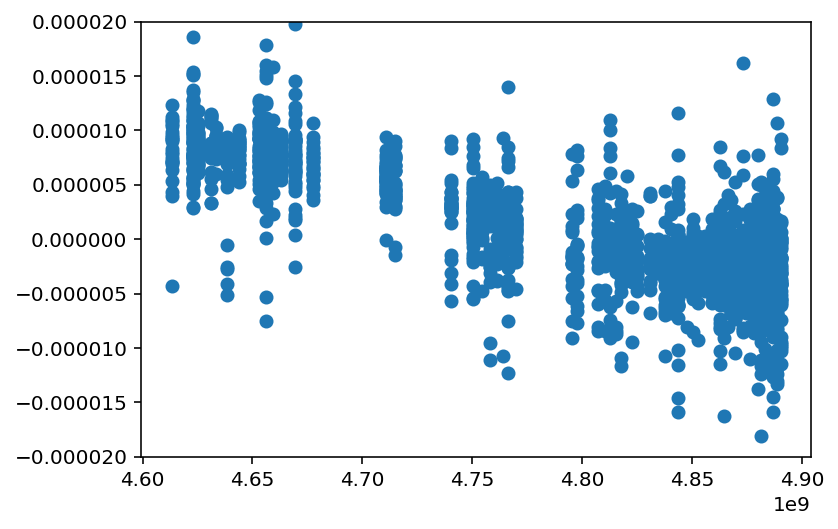

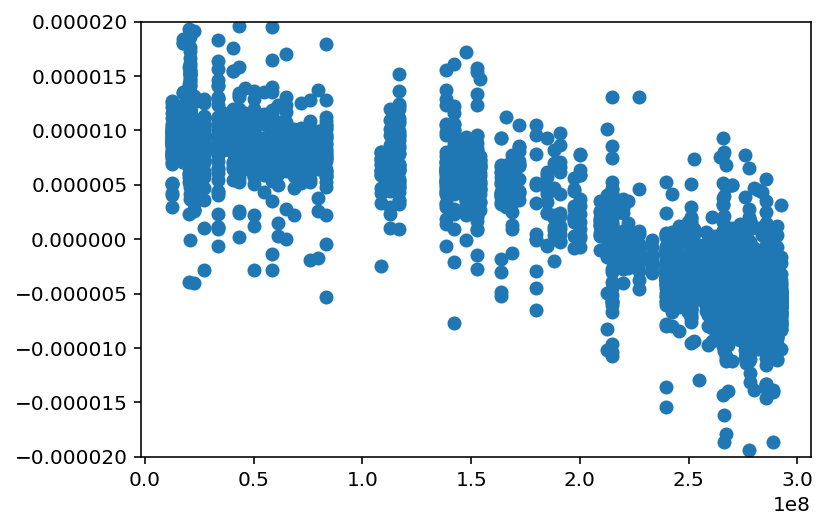

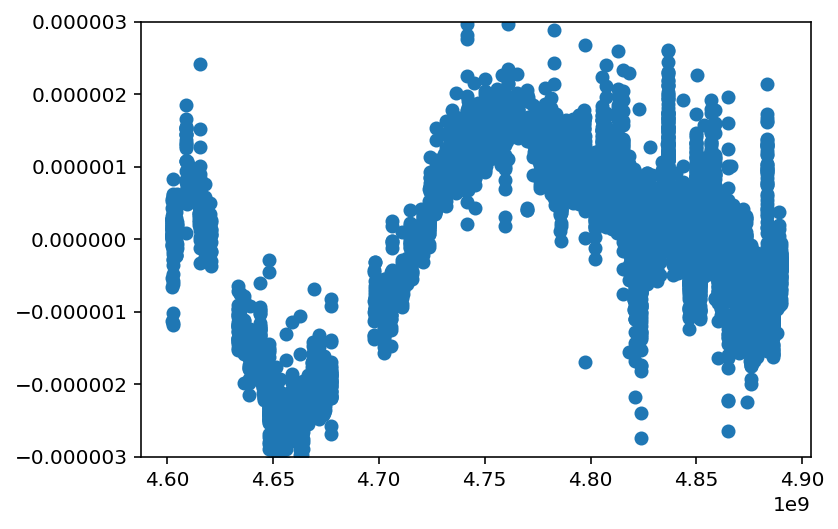

In [195]:
plt.scatter(pulsars[0].toas,pulsars[0].residuals)
plt.ylim([-2e-5,2e-5])
plt.show()

plt.scatter(newtoas[0],psrs[0].residuals)
plt.ylim([-2e-5,2e-5])
plt.show()

plt.scatter(pulsars[1].toas,pulsars[1].residuals)
plt.ylim([-3e-6,3e-6])
plt.show()



In [196]:
def AndrewFpstat(pta,psrs,f0):
    '''Takes in the full pta, the pulsars that make up the pta 
    (Should make this a function in ptas to use self instead of pta?),
    and the orbital frequency of the gravitational wave (usually the search parameter).
    Returns the Fp statistic
    '''
    params = pta.params #come up with a more clever way of doing this

    TNrs = pta.get_TNr(params)
    TNTs = pta.get_TNT(params)
    phiinvs = pta.get_phiinv(params, logdet=False, method='partition')
    
    #Get noise parameters for pta toaerr**2
    Nvecs = pta.get_ndiag(params)
    
    Ts = pta.get_basis(params)
    Nmat = []
    
    # make sure all pulsar have same reference time
    #Unsure if necessary
    tt=[] 
    for p in psrs:
        tt.append(np.min(p.toas))

    # find reference time
    tref = np.min(tt)
    newtoas = []
    # now scale pulsar time and convert to seconds
    for p in psrs:
        newtoas.append((p.toas - tref))
    
    fpstat = 0.0
    
    #Probably a better way of doing this as well, but using TNTs[ii] for example didn't work
    for ii,p in enumerate(psrs):
        phiinv, TNr, TNT, Nvec, T = phiinvs[ii], TNrs[ii], TNTs[ii], Nvecs[ii], Ts[ii]
        Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
        cf = sl.cho_factor(Sigma)      
        #Put pulsar's autoerrors in a diagonal matrix
        Ndiag = np.diag(1.0/Nvec)
        Tt = np.transpose(T)
        TtN = np.dot(Tt,Ndiag)
        expval2 = sl.cho_solve(cf,TtN)
        TtNt = np.transpose(TtN)
        
        #An Ntoa by Ntoa noise matrix to be used in expand dense matrix calculations earlier
        Nmat.append(Ndiag - np.dot(TtNt,expval2))
        
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(2)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((2, 2))

        # Define A vector
        A = np.zeros((2, len(p.toas)))
        A[0,:] = f0**(-1./3.) * np.sin(2*f0*newtoas[ii])
        A[1,:] = f0**(-1./3.) * np.cos(2*f0*newtoas[ii])
    
        # define N vectors from Ellis et al, 2012 N_i=(r|A_i) for each pulsar
        N = np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                      np.dot(A[1,:], np.dot(Nmat[ii],p.residuals))]) 
        
        # define M matrix M_ij=(A_i|A_j)
        for jj in range(2):
            for kk in range(2):
                M[jj,kk] = np.dot(A[jj,:], np.dot(Nmat[ii], A[kk,:]))
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        fpstat += 0.5 * np.dot(N, np.dot(Minv, N))
        
    return fpstat

In [197]:
print(AndrewFpstat(pta_test,pulsars,f0))
print(pta_test.get_lnlikelihood(xs_test))

4855.560585258421
151968.24209995792


In [198]:
print(AndrewFpstat(pta_full,psrs,f0))
print(pta_full.get_lnlikelihood(xs_full))

5667.978525105191
1785173.9742654767


In [70]:
n = 10
f0 = 7e-8

fstat_array = []
for i in range(n-1):
    fstat_array.append(AndrewFpstat(pta_full,psrs,f0))

In [74]:
print(fstat_array)

[7.366686254278224e-18, 7.366686254278224e-18, 7.366686254278224e-18, 7.366686254278224e-18, 7.366686254278224e-18, 7.366686254278224e-18, 7.366686254278224e-18, 7.366686254278224e-18, 7.366686254278224e-18]


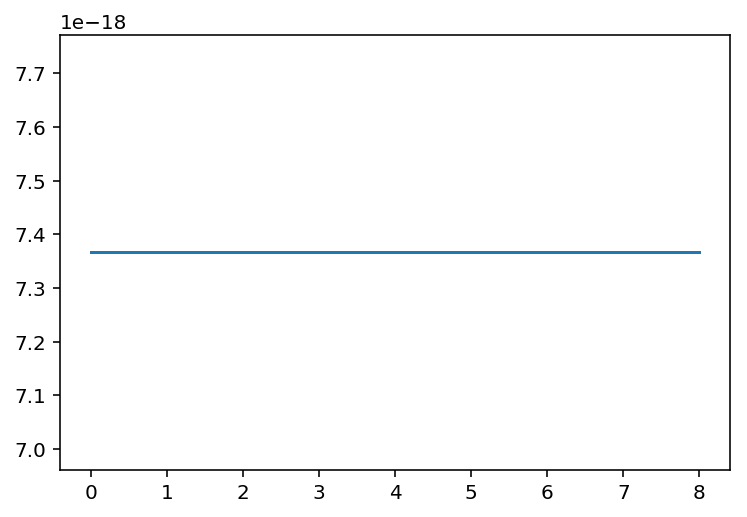

In [73]:
bins = range(n-1)
plt.plot(bins,fstat_array)

In [159]:
def AndrewFestat(pta,psrs,f0):
    '''Takes in the full pta, the pulsars that make up the pta 
    (Should make this a function in ptas to use self instead of pta?),
    and the orbital frequency of the gravitational wave (usually the search parameter).
    Returns the Fp statistic
    '''
    params = pta.params #come up with a more clever way of doing this

    TNrs = pta.get_TNr(params)
    TNTs = pta.get_TNT(params)
    phiinvs = pta.get_phiinv(params, logdet=False, method='partition')
    
    #Get noise parameters for pta (1/toaerr**2)
    Nvecs = pta.get_ndiag(params)
    Ts = pta.get_basis(params)
    Nmat = []
    
    festat = 0.0
    
    #Probably a better way of doing this as well, but using TNTs[ii] for example didn't work
    for ii,p in enumerate(psrs):
        phiinv, TNr, TNT, Nvec, T = phiinvs[ii], TNrs[ii], TNTs[ii], Nvecs[ii], Ts[ii]
        Sigma = TNT + (np.diag(phiinv) if phiinv.ndim == 1 else phiinv)
        cf = sl.cho_factor(Sigma)      
        #Put pulsar's autoerrors in a diagonal matrix
        Ndiag = np.diag(Nvec)
        Tt = np.transpose(T)
        TtN = np.dot(Tt,Ndiag)
        expval2 = sl.cho_solve(cf,TtN)
        TtNt = np.transpose(TtN)
        
        #An Ntoa by Ntoa noise matrix to be used in expand dense matrix calculations earlier
        Nmat.append(Ndiag - np.dot(TtNt,expval2))
        
        # define N vectors from Ellis et al, 2012 N_i=(x|A_i) for each pulsar
        N = np.zeros(4)
        # define M matrix M_ij=(A_i|A_j)
        M = np.zeros((4,4))

        fplus, fcross, cosMu = createAntennaPatternFuncs(p, gwtheta, gwphi)

        # define A
        A = np.zeros((4, len(p.toas)))
        A[0,:] = fplus/f0**(1./3.) * np.sin(2*f0*p.toas)
        A[1,:] = fplus/f0**(1./3.) * np.cos(2*f0*p.toas)
        A[2,:] = fcross/f0**(1./3.) * np.sin(2*f0*p.toas)
        A[3,:] = fcross/f0**(1./3.) * np.cos(2*f0*p.toas)


    N += np.array([np.dot(A[0,:], np.dot(p.invCov, p.res)), \
                    np.dot(A[1,:], np.dot(p.invCov, p.res)), \
                    np.dot(A[2,:], np.dot(p.invCov, p.res)), \
                    np.dot(A[3,:], np.dot(p.invCov, p.res))])
        

        # Define A vector
        A = np.zeros((2, len(p.toas)))
        A[0,:] = f0**(-1./3.) * np.sin(2*f0*p.toas)
        A[1,:] = f0**(-1./3.) * np.cos(2*f0*p.toas)
    
        # define N vectors from Ellis et al, 2012 N_i=(r|A_i) for each pulsar
        N = np.array([np.dot(A[0,:], np.dot(Nmat[ii],p.residuals)), \
                      np.dot(A[1,:], np.dot(Nmat[ii],p.residuals))]) 
        
        # define M matrix M_ij=(A_i|A_j)
        for jj in range(2):
            for kk in range(2):
                M[jj,kk] = np.dot(A[jj,:], np.dot(Nmat[ii], A[kk,:]))
        
        # take inverse of M
        Minv = sl.pinv(M)
        
        fpstat += 0.5 * np.dot(N, np.dot(Minv, N))
        
    return fpstat